<H2> Initialization

In [216]:
import tensorflow as tf, pandas as pd, numpy as np # most-required libraries
import matplotlib.pyplot as plt, seaborn as sns # data visualization

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import InputLayer, Normalization, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam # optimizers
from tensorflow.keras.metrics import RootMeanSquaredError

from tensorflow.data import Dataset

from sklearn.metrics import r2_score

In [217]:
data = pd.read_csv ('/content/train.csv', sep = ',')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,airconditioning,furnishingstatus,hotwaterheating,parking,prefarea
0,13300000,7420,4,2,3,yes,yes,furnished,no,2,yes
1,12250000,8960,4,4,4,yes,yes,furnished,no,3,no
2,12250000,9960,3,2,2,yes,no,semi-furnished,no,2,yes
3,12215000,7500,4,2,2,yes,yes,furnished,no,3,yes
4,11410000,7420,4,1,2,yes,yes,furnished,no,2,no


Q. Like in this code how does code knows that `plt.show()` means to draw "plot" name plot ? <br>

When you call `plt.show()`, it triggers the display of the last figure that was created in the current Python session.

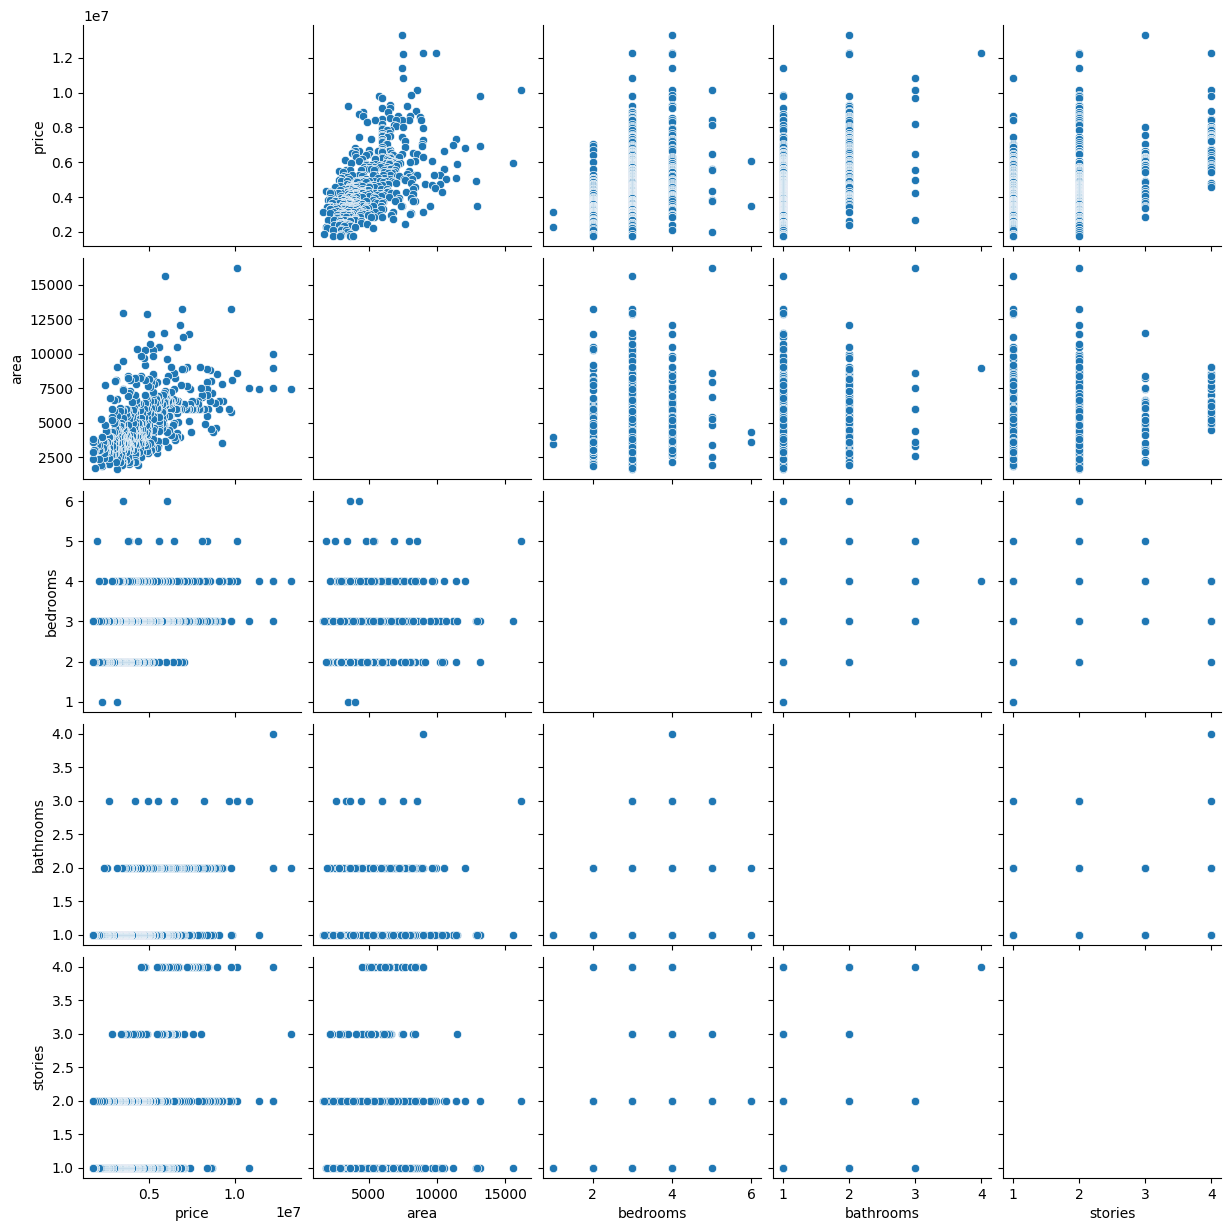

In [218]:
plot = sns.pairplot (data[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad']], diag_kind='reg')
plt.show()

<H2> Data Preparation

In [219]:
# converting the string-type data into numerical format that the system can understand
label_encoder= LabelEncoder()

string_columns = ['mainroad', 'airconditioning', 'hotwaterheating', 'prefarea'] # binary-encoding-needed
for items in string_columns :
  data[items] = label_encoder.fit_transform (data[items])

data['furnishingstatus'] = label_encoder.fit_transform (data['furnishingstatus'])

print(data.shape); data.head()

(545, 11)


,price,area,bedrooms,bathrooms,stories,mainroad,airconditioning,furnishingstatus,hotwaterheating,parking,prefarea
0,13300000,7420,4,2,3,1,1,0,0,2,1
1,12250000,8960,4,4,4,1,1,0,0,3,0
2,12250000,9960,3,2,2,1,0,1,0,2,1
3,12215000,7500,4,2,2,1,1,0,0,3,1
4,11410000,7420,4,1,2,1,1,0,0,2,0


In [220]:
# creating tensor and shuffling must go hand-in-hand -> always remember to shuffle the data to avoid any linearity in the model
tensor = tf.constant (data, dtype = tf.float32); tensor = tf.random.shuffle (tensor)

x, y = tensor[:, 1:8] , tensor[:, 0]
y = tf.expand_dims (y, axis= -1); print(x.shape, y.shape)

dataset_size = len(x)
train_ratio, val_ratio, test_ratio= 0.8, 0.1, 0.1

x_train, y_train = x[:int(dataset_size*train_ratio)], y[:int(dataset_size * train_ratio)]
print(x_train.shape, y_train.shape)

x_val = x[int(dataset_size*train_ratio) : int(dataset_size*(train_ratio+val_ratio))]
y_val = y[int(dataset_size*train_ratio) : int(dataset_size*(train_ratio+val_ratio))]
print(x_val.shape , y_val.shape)

x_test = x[int(dataset_size*(train_ratio+val_ratio)):]
y_test = y[int(dataset_size*(train_ratio+val_ratio)):] ; print(x_test.shape, y_test.shape)

(545, 7) (545, 1)
(436, 7) (436, 1)
(54, 7) (54, 1)
(55, 7) (55, 1)


In [221]:
train_dataset = Dataset.from_tensor_slices ((x_train, y_train))
val_dataset = Dataset.from_tensor_slices ((x_val, y_val))
test_dataset = Dataset.from_tensor_slices ((x_test, y_test))

train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

<H2> Model Building

In [222]:
normalizer = Normalization(); normalizer.adapt(x_train)

In [223]:
model = tf.keras.Sequential ([
    InputLayer (input_shape = (7,)),
    normalizer,
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense (1),
])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normaliza  (None, 7)                 15        
 tion)                                                           
                                                                 
 dense_50 (Dense)            (None, 128)               1024      
                                                                 
 dense_51 (Dense)            (None, 128)               16512     
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dense_53 (Dense)            (None, 1)                 129       
                                                                 
Total params: 34192 (133.57 KB)
Trainable params: 34177 (133.50 KB)
Non-trainable params: 15 (64.00 Byte)
_____________

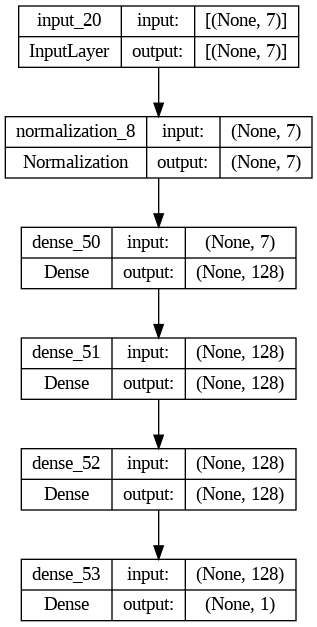

In [224]:
tf.keras.utils.plot_model (model, 'model.png', show_shapes =True)

In [225]:
model.compile (
    loss = MeanAbsoluteError(),
    optimizer = Adam (learning_rate = 0.5),
    metrics = RootMeanSquaredError(),
)

<H2> Model Training and Optimization

In [226]:
history = model.fit (
    train_dataset,
    batch_size = 32,
    epochs = 100,
    validation_data = val_dataset,
)

Epoch 1/100
14/14 [==============================] - 1s 12ms/step - loss: 2670619.5000 - root_mean_squared_error: 3205909.2500 - val_loss: 1991780.8750 - val_root_mean_squared_error: 2559232.2500
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 1326362.7500 - root_mean_squared_error: 1873874.3750 - val_loss: 1381882.6250 - val_root_mean_squared_error: 1733038.5000
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1060716.0000 - root_mean_squared_error: 1422557.6250 - val_loss: 991748.5625 - val_root_mean_squared_error: 1340182.5000
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 1003832.6875 - root_mean_squared_error: 1362237.2500 - val_loss: 1269301.3750 - val_root_mean_squared_error: 1718279.8750
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 981713.9375 - root_mean_squared_error: 1310163.1250 - val_loss: 938463.5000 - val_root_mean_squared_error: 1307496.5000
Epoch 6/100
14/14 [========

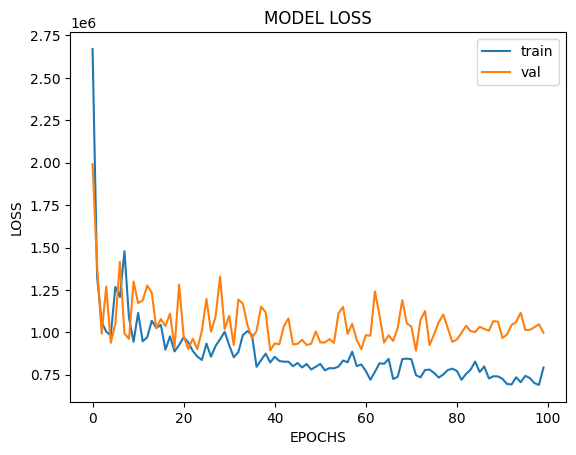

In [227]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot (loss) ; plt.plot (val_loss)
plt.xlabel ('EPOCHS'); plt.ylabel ('LOSS'); plt.title ('MODEL LOSS')
plt.legend(['train', 'val'])
plt.show()

In [228]:
model.evaluate (test_dataset)

2/2 [==============================] - 0s 8ms/step - loss: 1010996.8750 - root_mean_squared_error: 1436455.0000


[1010996.875, 1436455.0]

2/2 [==============================] - 0s 8ms/step
[5250000.0, 3430000.0, 5250000.0, 3500000.0, 2275000.0, 4760000.0, 3990000.0, 4690000.0, 7490000.0, 8645000.0, 12250000.0, 6895000.0, 2730000.0, 3836000.0, 5495000.0, 5523000.0, 3710000.0, 4550000.0, 3395000.0, 6300000.0, 3395000.0, 1750000.0, 2660000.0, 5950000.0, 4200000.0, 7035000.0, 3150000.0, 3675000.0, 10150000.0, 6020000.0, 3290000.0, 5460000.0, 4340000.0, 4270000.0, 3010000.0, 3115000.0, 3920000.0, 2233000.0, 3150000.0, 3745000.0, 6650000.0, 4305000.0, 3885000.0, 4970000.0, 5740000.0, 8463000.0, 3710000.0, 4620000.0, 2520000.0, 6615000.0, 8960000.0, 3465000.0, 2450000.0, 3430000.0, 4900000.0]
[7243998.5, 3146507.8, 6154876.0, 4926968.5, 3609216.0, 6743184.5, 4922866.0, 4729275.0, 6649289.5, 7283165.5, 5506890.5, 6425721.5, 3622784.0, 3328814.2, 5149519.5, 5310233.0, 3877338.0, 4194561.0, 5383139.0, 6792624.0, 3499762.8, 3554944.2, 3815754.5, 5515382.5, 2902747.8, 8454807.0, 5330830.5, 2908246.5, 11409225.0, 6462646.5, 5416985.0

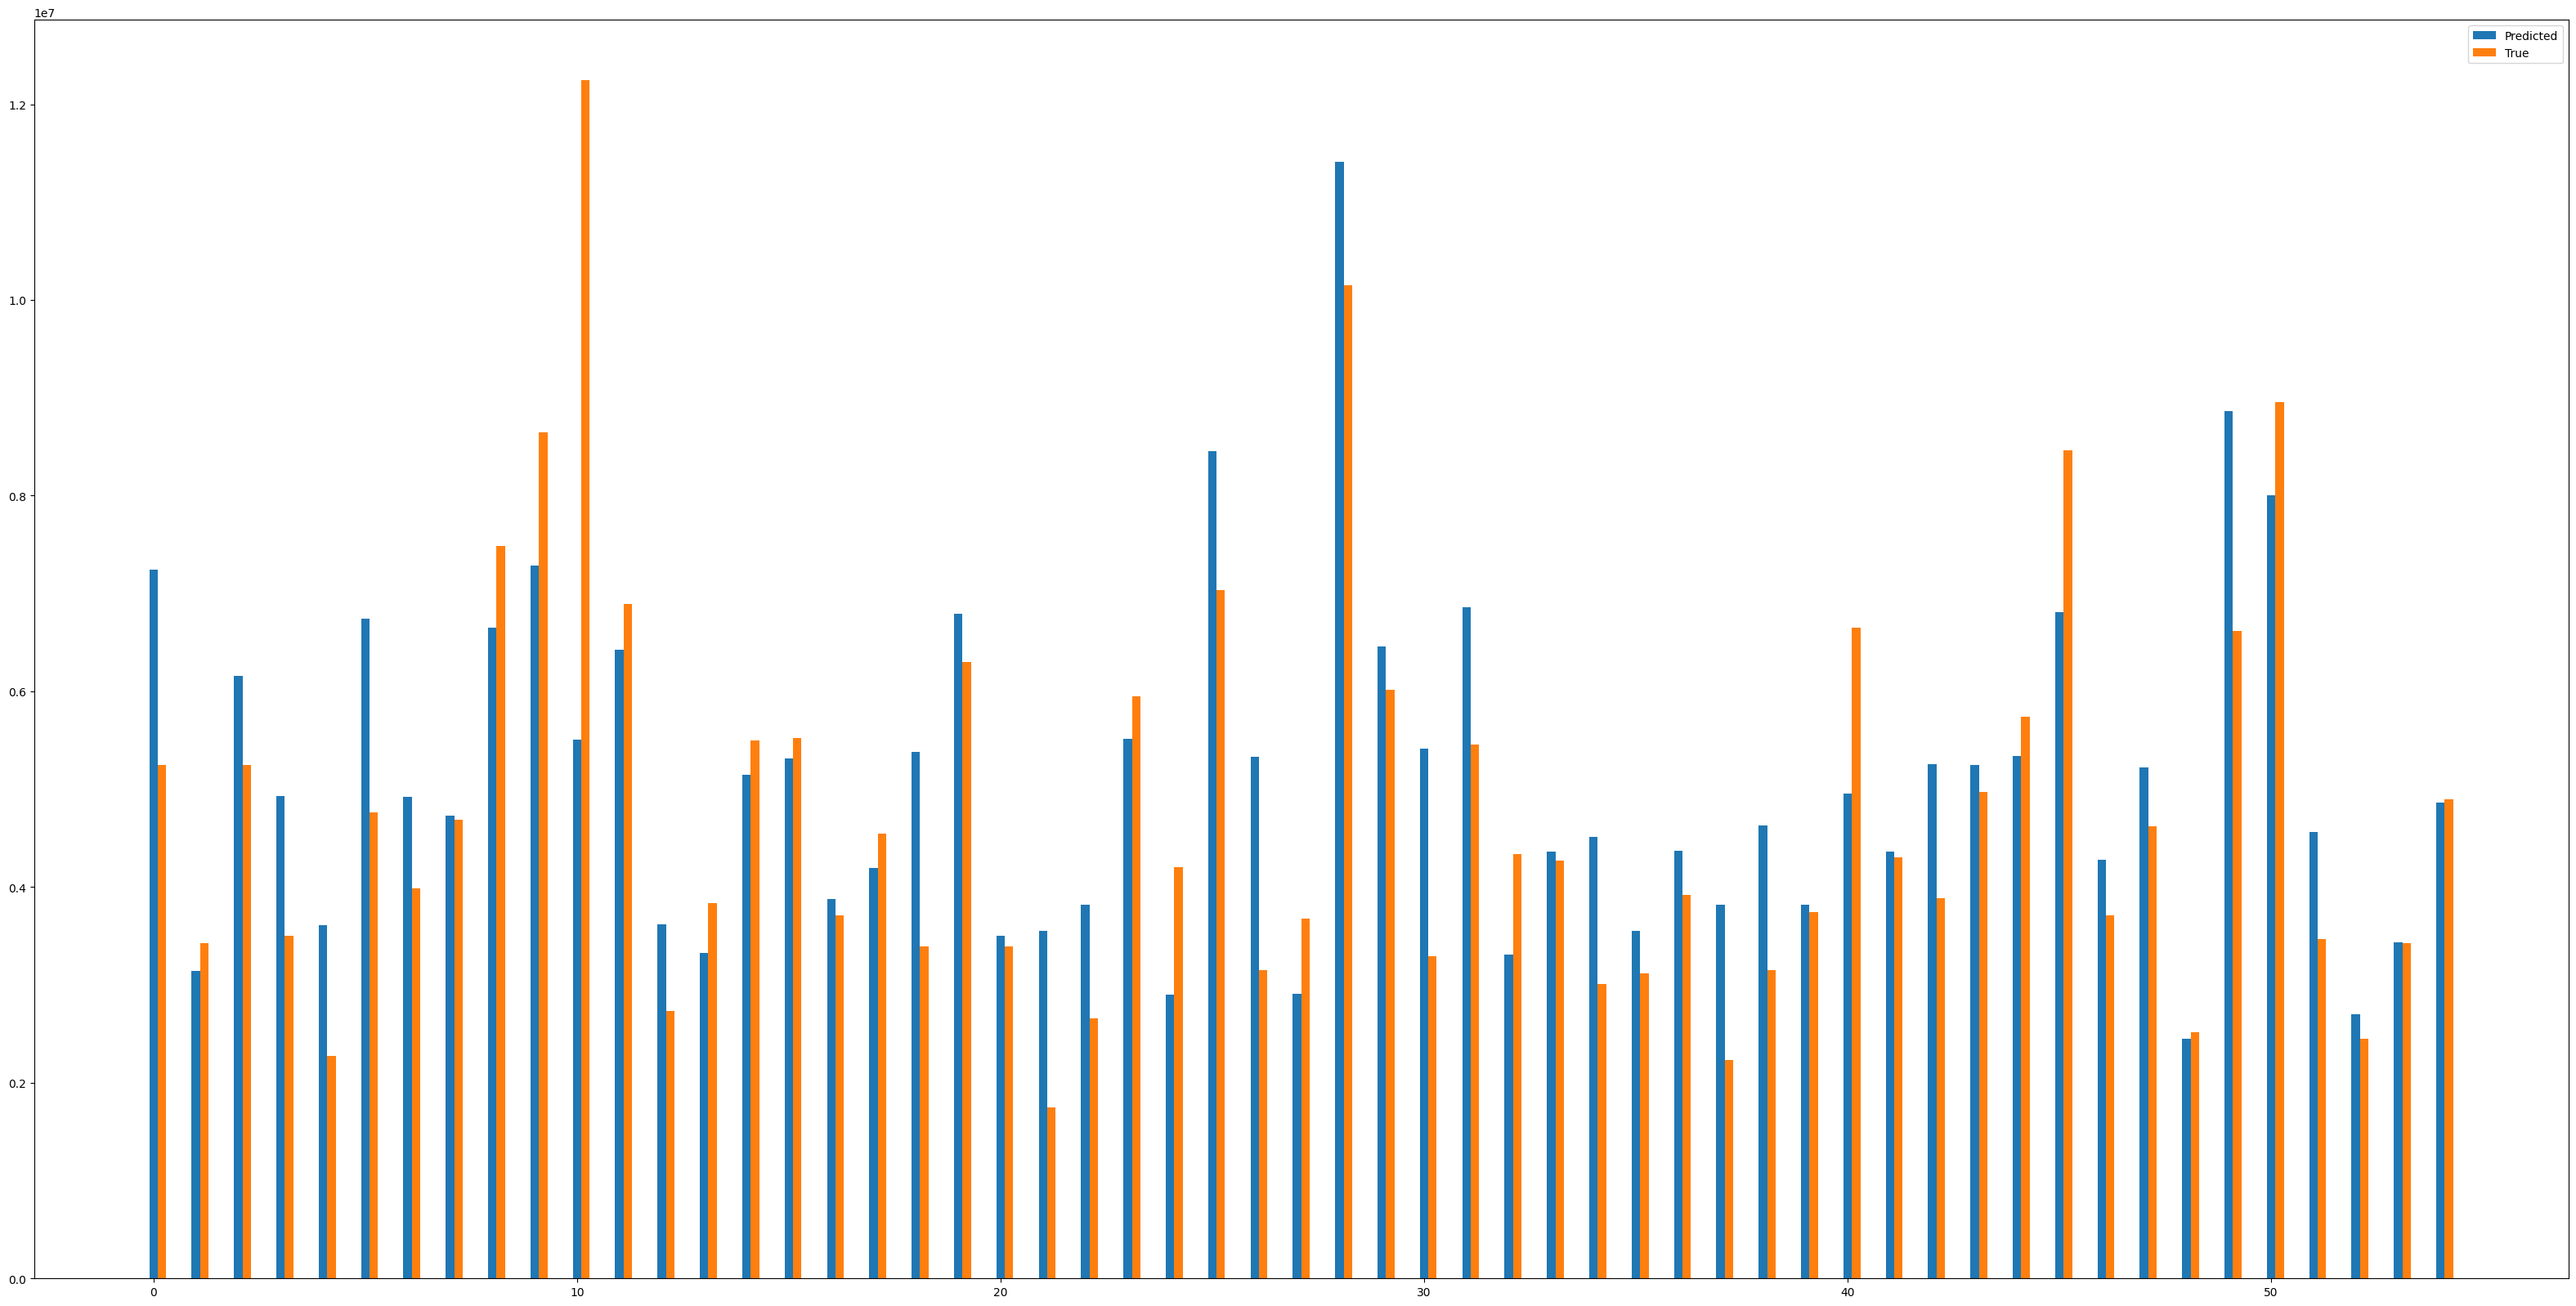

In [229]:
y_true = list(y_test[:, 0].numpy())
y_pred = list(model.predict(x_test)[:, 0])

print(y_true) ; print(y_pred)

index = np.arange(len(y_true))
plt.figure (figsize = (40, 20)) ; width = 0.2

plt.bar(index, y_pred, width, label = 'predicted')
plt.bar(index+width, y_true, width, label = 'true')

plt.legend (['Predicted', 'True'])
plt.show()

In [230]:
score1 = r2_score(y_true, y_pred) ; acc= score1*100 ; print(acc)

52.062499928222095
